In [56]:
import os
import pandas as pd
from PIL import Image
import numpy as np

def create_dataset_csv(data_dir, output_csv, image_size=(48, 48)):
    """
    Create a CSV file from an image dataset.
    :param data_dir: Root directory of the dataset (organized by class folders).
    :param output_csv: Path to save the output CSV file.
    :param image_size: Tuple specifying the size to which images will be resized.
    """
    data = []
    for emotion in os.listdir('/content/dataset'):
        emotion_dir = os.path.join(data_dir, emotion)
        if os.path.isdir(emotion_dir):
            for img_file in os.listdir(emotion_dir):
                img_path = os.path.join(emotion_dir, img_file)
                try:
                    # Open image and preprocess
                    img = Image.open(img_path).convert('L')  # Convert to grayscale
                    img = img.resize(image_size)  # Resize to target dimensions
                    img_data = np.asarray(img).flatten()  # Flatten image array
                    data.append({
                        'pixels': ' '.join(map(str, img_data)),
                        'emotion': emotion
                    })
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")

    # Save the dataset to a CSV file
    df = pd.DataFrame(data)
    df.to_csv(output_csv, index=False)
    print(f"Dataset saved to {output_csv}")

# Example usage:
data_directory = "path_to_your_dataset_folder"
output_csv_file = "human_face_emotions.csv"
create_dataset_csv(data_directory, output_csv_file)


Dataset saved to human_face_emotions.csv


In [57]:
!python /content/emotion_ai.py

Traceback (most recent call last):
  File "/content/emotion_ai.py", line 80, in <module>
    images, labels = load_data(data_path)
  File "/content/emotion_ai.py", line 12, in load_data
    data = pd.read_csv(data_path)
  File "/usr/local/lib/python3.10/dist-packages/pandas/io/parsers/readers.py", line 1026, in read_csv
    return _read(filepath_or_buffer, kwds)
  File "/usr/local/lib/python3.10/dist-packages/pandas/io/parsers/readers.py", line 620, in _read
    parser = TextFileReader(filepath_or_buffer, **kwds)
  File "/usr/local/lib/python3.10/dist-packages/pandas/io/parsers/readers.py", line 1620, in __init__
    self._engine = self._make_engine(f, self.engine)
  File "/usr/local/lib/python3.10/dist-packages/pandas/io/parsers/readers.py", line 1898, in _make_engine
    return mapping[engine](f, **self.options)
  File "/usr/local/lib/python3.10/dist-packages/pandas/io/parsers/c_parser_wrapper.py", line 93, in __init__
    self._reader = parsers.TextReader(src, **kwds)
  File "parser

In [1]:
!pip install kaggle

In [2]:
from google.colab import  files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ouhabest","key":"55540677ea53a4b137354aeef8522def"}'}

In [3]:
# Create a Kaggle folder and move the uploaded file
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Set permissions


In [5]:
!kaggle datasets download -d sanidhyak/human-face-emotions

Dataset URL: https://www.kaggle.com/datasets/sanidhyak/human-face-emotions
License(s): other
 89% 72.0M/80.5M [00:00<00:00, 170MB/s]
100% 80.5M/80.5M [00:00<00:00, 154MB/s]


In [6]:
!unzip human-face-emotions.zip -d dataset


Archive:  human-face-emotions.zip
  inflating: dataset/data/Angry/0346f330983a068db0633f96d4a13de873-06-angry.rsquare.w700.jpg  
  inflating: dataset/data/Angry/118-1183761_angry-person-transparent-images-png-angry-man-png.png  
  inflating: dataset/data/Angry/118-1183847_angry-person-png-picture.png  
  inflating: dataset/data/Angry/139-1393790_angry-person-png-pic-angry-man-clipart-png.png  
  inflating: dataset/data/Angry/1564075.jpg  
  inflating: dataset/data/Angry/19_1016_DISCIPLESHIP_How-to-Deal-With-Angry-People_1021x640-696x436.jpg  
  inflating: dataset/data/Angry/32209658.jpg  
  inflating: dataset/data/Angry/3710928.jpg  
  inflating: dataset/data/Angry/40-bigstock-Mad-fight-of-business-people-61801940.jpg  
  inflating: dataset/data/Angry/439-4398363_angry-man-png-pictures-angry-person-png-transparent.png  
  inflating: dataset/data/Angry/5cd88fd321000035007f6cd2.jpeg  
  inflating: dataset/data/Angry/60552212-angry-people-illustration-design-collection.jpg  
  inflating: 

In [18]:
pip install tensorflow opencv-python


In [19]:

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2
import os

# Set the path to the dataset
DATASET_PATH = '/content/dataset'
IMAGE_SIZE = (64, 64)
BATCH_SIZE = 32

# Prepare the data
datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)

train_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Build the neural network model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # 3 classes: Angry, Happy, Sad
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10
)

# Save the trained model
model.save('emotion_recognition_model.h5')

# Load and predict on a new image
def predict_emotion(image_path, model, class_indices):
    # Preprocess the image
    image = cv2.imread(image_path)
    image = cv2.resize(image, IMAGE_SIZE)
    image = np.expand_dims(image, axis=0) / 255.0

    # Predict the emotion
    prediction = model.predict(image)
    class_idx = np.argmax(prediction)
    class_labels = {v: k for k, v in class_indices.items()}
    emotion = class_labels[class_idx]
    return emotion

# Load the saved model
model = tf.keras.models.load_model('emotion_recognition_model.h5')

# Test the model with a new image
uploaded_image_path = '/path/to/uploaded/image.jpg'  # Replace with the actual image path
emotion = predict_emotion(uploaded_image_path, model, train_generator.class_indices)
print(f"The predicted emotion is: {emotion}")


Found 212 images belonging to 3 classes.
Found 52 images belonging to 3 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 602ms/step - accuracy: 0.2734 - loss: 1.1649 - val_accuracy: 0.4423 - val_loss: 1.0765
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 566ms/step - accuracy: 0.4463 - loss: 1.0597 - val_accuracy: 0.3846 - val_loss: 1.0661
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 373ms/step - accuracy: 0.3337 - loss: 1.0860 - val_accuracy: 0.4615 - val_loss: 1.0657
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 371ms/step - accuracy: 0.4235 - loss: 1.0556 - val_accuracy: 0.5385 - val_loss: 1.0417
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 409ms/step - accuracy: 0.4805 - loss: 1.0171 - val_accuracy: 0.4808 - val_loss: 1.0330
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 368ms/step - accuracy: 0.4828 - loss: 1.0074 - val_accuracy: 0.4615 - val_loss: 1.0274
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 405ms/step - accuracy: 0.4749 - loss: 1.0142 - val_accuracy: 0.5000 - val_loss: 1.0097
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 373ms/step - accuracy: 0.5796 - loss: 0.9270 - val_accuracy: 0.4423 - val_loss: 1.0750


error: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [29]:
!cat /content/emotion_ai.py

import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from PIL import Image

# Define the dataset directory
dataset_dir = "/content/dataset"

# Preprocess the dataset
def load_data(dataset_dir, image_size=(48, 48)):
    images = []
    labels = []
    # Iterate through each emotion folder
    for label in os.listdir(dataset_dir):
        label_path = os.path.join(dataset_dir, label)
        if os.path.isdir(label_path):  # Check if it's a directory
            for file in os.listdir(label_path):
                file_path = os.path.join(label_path, file)
                try:
                    # Open and resize the image
                    img = Image.open(file_path).convert("L")  # Convert to grayscale
                    img = img.resize(image_size)
                    images.append(np.array(img).flatten())  # Flatten the image
                    labels.append

In [28]:
%%writefile /content/emotion_ai.py
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from PIL import Image

# Define the dataset directory
dataset_dir = "/content/dataset"

# Preprocess the dataset
def load_data(dataset_dir, image_size=(48, 48)):
    images = []
    labels = []
    # Iterate through each emotion folder
    for label in os.listdir(dataset_dir):
        label_path = os.path.join(dataset_dir, label)
        if os.path.isdir(label_path):  # Check if it's a directory
            for file in os.listdir(label_path):
                file_path = os.path.join(label_path, file)
                try:
                    # Open and resize the image
                    img = Image.open(file_path).convert("L")  # Convert to grayscale
                    img = img.resize(image_size)
                    images.append(np.array(img).flatten())  # Flatten the image
                    labels.append(label)
                except Exception as e:
                    print(f"Error processing file {file_path}: {e}")
    return np.array(images), np.array(labels)

# Load the data
images, labels = load_data(dataset_dir)

# Encode labels into numerical values
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Split the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"Data loaded. Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")


Overwriting /content/emotion_ai.py


In [30]:
%%writefile /content/emotion_ai.py
class Adaline:
    def __init__(self, learning_rate=0.01, epochs=100):
        self.learning_rate = learning_rate
        self.epochs = epochs

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        self.errors_ = []

        for _ in range(self.epochs):
            errors = 0
            for xi, target in zip(X, y):
                output = self.net_input(xi)
                error = target - output
                self.weights += self.learning_rate * error * xi
                self.bias += self.learning_rate * error
                errors += int(error != 0.0)
            self.errors_.append(errors)

    def net_input(self, X):
        return np.dot(X, self.weights) + self.bias

    def predict(self, X):
        return np.where(self.net_input(X) >= 0.0, 1, -1)

# Train Adaline
adaline = Adaline(learning_rate=0.01, epochs=50)
adaline.fit(X_train, y_train)

# Predict on test set
y_pred = adaline.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print(f"Adaline Accuracy: {accuracy:.2f}")


Overwriting /content/emotion_ai.py


In [31]:
%%writefile /content/emotion_ai.py
class Madaline:
    def __init__(self, input_size, output_size, hidden_size, learning_rate=0.01, epochs=100):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights_hidden = np.random.randn(self.hidden_size, self.input_size)
        self.bias_hidden = np.zeros(self.hidden_size)
        self.weights_output = np.random.randn(self.output_size, self.hidden_size)
        self.bias_output = np.zeros(self.output_size)

    def activation(self, x):
        return np.where(x >= 0, 1, 0)

    def fit(self, X, y):
        for _ in range(self.epochs):
            for xi, target in zip(X, y):
                hidden_input = np.dot(self.weights_hidden, xi) + self.bias_hidden
                hidden_output = self.activation(hidden_input)
                final_input = np.dot(self.weights_output, hidden_output) + self.bias_output
                final_output = self.activation(final_input)

                error = target - final_output
                self.weights_output += self.learning_rate * np.outer(error, hidden_output)
                self.bias_output += self.learning_rate * error

    def predict(self, X):
        predictions = []
        for xi in X:
            hidden_input = np.dot(self.weights_hidden, xi) + self.bias_hidden
            hidden_output = self.activation(hidden_input)
            final_input = np.dot(self.weights_output, hidden_output) + self.bias_output
            final_output = self.activation(final_input)
            predictions.append(final_output)
        return np.array(predictions)

# Train Madaline
madaline = Madaline(input_size=X_train.shape[1], hidden_size=20, output_size=len(np.unique(y_train)))
madaline.fit(X_train, y_train)

# Predict and evaluate
y_pred = madaline.predict(X_test)
accuracy = np.mean(np.argmax(y_pred, axis=1) == y_test)
print(f"Madaline Accuracy: {accuracy:.2f}")


Overwriting /content/emotion_ai.py


In [66]:
import os

def rename_images(dataset_dir):
    """
    Rename all images in the dataset directory to follow a consistent naming convention.
    :param dataset_dir: Path to the root dataset folder (organized by class).
    """
    if not os.path.exists(dataset_dir):
        print("Dataset directory does not exist.")
        return

    for label in os.listdir(dataset_dir):
        class_dir = os.path.join(dataset_dir, label)
        if os.path.isdir(class_dir):  # Check if it's a folder
            print(f"Renaming images in class: {label}")
            for idx, img_file in enumerate(os.listdir(class_dir)):
                old_path = os.path.join(class_dir, img_file)
                # Ensure it's a valid image file
                if os.path.isfile(old_path) and img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    new_name = f"{label}_{idx + 1}.jpg"  # Rename to format: Class_Index.jpg
                    new_path = os.path.join(class_dir, new_name)
                    os.rename(old_path, new_path)
                    print(f"Renamed: {old_path} -> {new_path}")
                else:
                    print(f"Skipping: {old_path} (not a valid image file)")

# Update the path to your dataset directory
dataset_dir = "/content/dataset"  # Replace with your dataset directory path
rename_images(dataset_dir)


Renaming images in class: Angry
Renamed: /content/dataset/Angry/flat-of-two-angry-people-vector-18548440.jpg -> /content/dataset/Angry/Angry_1.jpg
Renamed: /content/dataset/Angry/angry-person-png-free-image-angry-kid-png-transparent-115629678417zic9bd9z6.png -> /content/dataset/Angry/Angry_2.jpg
Renamed: /content/dataset/Angry/angry-people-screaming-group-men-women-frustrated-shouting-78341909.jpg -> /content/dataset/Angry/Angry_3.jpg
Renamed: /content/dataset/Angry/Depositphotos_6311024_XL-1.jpg -> /content/dataset/Angry/Angry_4.jpg
Renamed: /content/dataset/Angry/single-angry-person-mobile-phone-260nw-603267953.jpg -> /content/dataset/Angry/Angry_5.jpg
Renamed: /content/dataset/Angry/32209658.jpg -> /content/dataset/Angry/Angry_6.jpg
Renamed: /content/dataset/Angry/images18.jpg -> /content/dataset/Angry/Angry_7.jpg
Renamed: /content/dataset/Angry/YdGPmBa6UZj8pxM95T2ADA-320-80.jpg -> /content/dataset/Angry/Angry_8.jpg
Renamed: /content/dataset/Angry/How-Anger-Affects-Health-of-Person.

In [9]:
import pandas as pd
from PIL import Image
import os

def resize_images(input_directory, output_directory, target_size=(48, 48)):
    """
    Resize images to the target size and save them to a new directory.
    :param input_directory: Path to the directory containing the original images.
    :param output_directory: Path to the directory to save resized images.
    :param target_size: Tuple specifying the target size (width, height).
    """
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    for root, dirs, files in os.walk(input_directory):
        for file in files:
            input_path = os.path.join(root, file)
            output_path = os.path.join(output_directory, file)

            try:
                # Open and resize the image
                img = Image.open(input_path)
                img = img.resize(target_size, Image.Resampling.LANCZOS)
                img.save(output_path)
                print(f"Resized and saved: {output_path}")
            except Exception as e:
                print(f"Error processing {input_path}: {e}")

# Example usage
input_directory = "/content/dataset"  # Replace with the path to your dataset
output_directory = "/content/dataset_resized"  # Replace with the path to save resized images
resize_images(input_directory, output_directory, target_size=(48, 48))


Resized and saved: /content/dataset_resized/Angry_4.jpg
Resized and saved: /content/dataset_resized/Angry_7.jpg
Resized and saved: /content/dataset_resized/Angry_16.jpg
Resized and saved: /content/dataset_resized/Angry_5.jpg
Resized and saved: /content/dataset_resized/Angry_40.jpg
Resized and saved: /content/dataset_resized/Angry_34.jpg
Resized and saved: /content/dataset_resized/Angry_86.jpg
Resized and saved: /content/dataset_resized/Angry_17.jpg
Resized and saved: /content/dataset_resized/Angry_85.jpg
Resized and saved: /content/dataset_resized/Angry_15.jpg
Resized and saved: /content/dataset_resized/Angry_18.jpg
Resized and saved: /content/dataset_resized/Angry_83.jpg
Resized and saved: /content/dataset_resized/Angry_56.jpg
Resized and saved: /content/dataset_resized/Angry_47.jpg
Resized and saved: /content/dataset_resized/Angry_79.jpg
Error processing /content/dataset/Angry/Angry_39.jpg: cannot write mode RGBA as JPEG
Resized and saved: /content/dataset_resized/Angry_14.jpg
Resize

In [4]:
def create_csv_from_images(data_dir, csv_file, image_size=(48, 48)):
    data = []
    for label in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, label)
        if os.path.isdir(class_dir):  # Ensure it's a directory
            for img_file in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_file)
                try:
                    print(f"Processing: {img_path}")
                    img = Image.open(img_path).convert('L')  # Convert to grayscale
                    img = img.resize(image_size)
                    img_array = np.asarray(img).flatten()
                    data.append({
                        'pixels': ' '.join(map(str, img_array)),
                        'emotion': label
                    })
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")

    # Save to CSV
    df = pd.DataFrame(data)
    df.to_csv(csv_file, index=False)
    print(f"CSV file saved at {csv_file}")

if __name__ == "__main__":
    dataset_dir = "/content/dataset"  # Update with your dataset folder path
    csv_file = "/content/human_face_emotions.csv"

    # Step 1: Create CSV from images
    if not os.path.exists(csv_file):
        print("Creating CSV file...")
        create_csv_from_images(dataset_dir, csv_file)

    # Step 2: Load data from CSV
    images, labels = load_data(csv_file)
    if images is None or labels is None:
        raise ValueError("Failed to load data from CSV.")

    # Step 3: Preprocess data
    images, labels_encoded, label_encoder = preprocess_data(images, labels)

    # Step 4: Split data
    X_train, X_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=0.2, random_state=42)

    # Step 5: Train and evaluate Adaline (Binary classification)
    adaline = Adaline(input_dim=X_train.shape[1], learning_rate=0.01, epochs=1000)
    adaline.train(X_train, y_train)
    y_pred_adaline = adaline.predict(X_test)
    print("Adaline Accuracy:", accuracy_score(y_test, y_pred_adaline))

    # Step 6: Train and evaluate Madaline (Multi-class classification)
    y_train_one_hot = np.eye(len(label_encoder.classes_))[y_train]
    madaline = Madaline(input_dim=X_train.shape[1], output_dim=len(label_encoder.classes_), learning_rate=0.01, epochs=1000)
    madaline.train(X_train, y_train_one_hot)
    y_pred_madaline = madaline.predict(X_test)
    y_pred_classes = np.argmax(y_pred_madaline, axis=1)
    print("Madaline Accuracy:", accuracy_score(y_test, y_pred_classes))


TypeError: preprocess_data() takes 1 positional argument but 2 were given

In [10]:
from google.colab import files

# Specify the file path you want to download
# files.download('/content/dataset')
!du -sh /content/dataset



83M	/content/dataset


In [7]:
# !pip install pandas numpy matplotlib scikit-learn pillow

!python /content/emotion_ai.py

  File "/content/emotion_ai.py", line 176
    run_gui(madaline, label_encoder)
SyntaxError: expected 'except' or 'finally' block


Madaline Accuracy: 0.41509433962264153
              precision    recall  f1-score   support

       Angry       0.44      0.33      0.38        21
       Happy       0.48      0.60      0.53        20
         Sad       0.25      0.25      0.25        12

    accuracy                           0.42        53
   macro avg       0.39      0.39      0.39        53
weighted avg       0.41      0.42      0.41        53



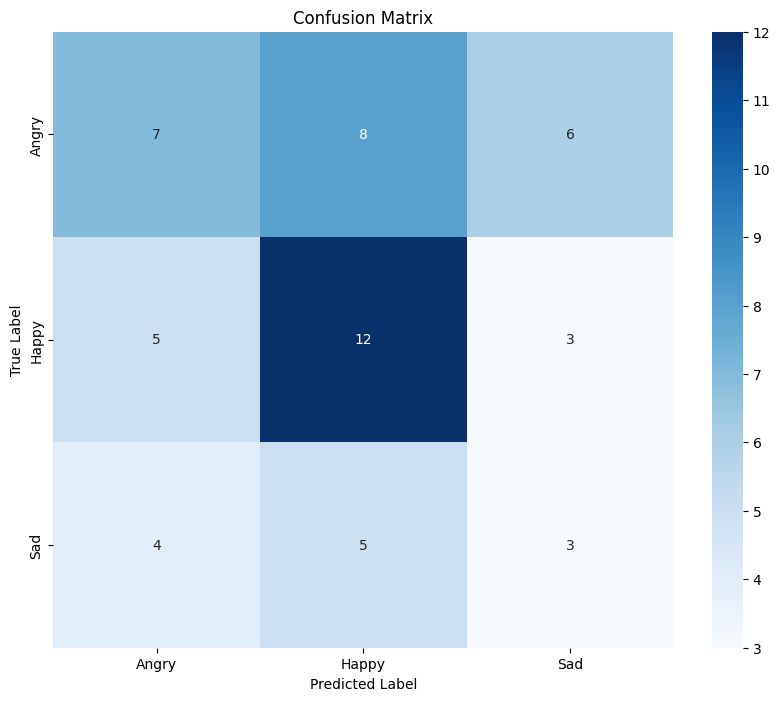

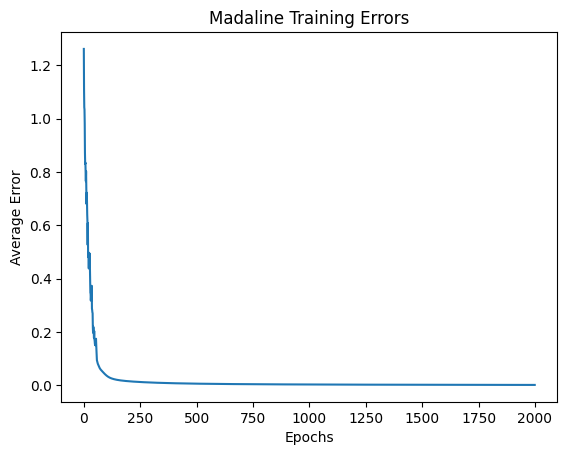

Enter image path for prediction (or 'exit'): exit


In [6]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Constants
DATASET_DIR = "/content/dataset"
CSV_FILE = "/content/human_face_emotions.csv"
IMG_SIZE = (48, 48)
LEARNING_RATE = 0.01
EPOCHS = 2000

# Data Loading and Preprocessing
def create_csv_from_images(data_dir, csv_file, image_size=IMG_SIZE):
    data = []
    for label in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, label)
        if os.path.isdir(class_dir):
            for img_file in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_file)
                try:
                    img = Image.open(img_path).convert('L').resize(image_size)
                    img_array = np.asarray(img).flatten()
                    data.append({'pixels': ' '.join(map(str, img_array)), 'emotion': label})
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")
    pd.DataFrame(data).to_csv(csv_file, index=False)

def load_data(csv_file):
    try:
        df = pd.read_csv(csv_file)
        images = np.array([np.fromstring(pixels, sep=' ') for pixels in df['pixels']]).reshape(-1, *IMG_SIZE)
        labels = df['emotion'].values
        return images, labels
    except Exception as e:
        print(f"Error loading CSV: {e}")
        return None, None

def preprocess_data(images):
    return images / 255.0

# Madaline Model (Improved for stability and multi-class)
class Madaline:
    def __init__(self, input_shape, num_classes, learning_rate=LEARNING_RATE, epochs=EPOCHS):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = np.random.normal(0, 0.1, (np.prod(input_shape), num_classes))  # Improved initialization
        self.bias = np.zeros(num_classes)
        self.errors_ = []

    def activation(self, x):
        return np.where(x >= 0, 1, -1) # Bipolar activation

    def softmax(self,x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def fit(self, X, y):
        X = X.reshape(X.shape[0], -1)  # Flatten input
        for epoch in range(self.epochs):
            errors_epoch = 0
            for i in range(len(X)):
                xi = X[i]
                target = y[i]
                net_input = np.dot(xi, self.weights) + self.bias
                output = self.softmax(net_input.reshape(1,-1))[0]
                error = target - output
                errors_epoch += np.sum(np.abs(error))

                self.weights += self.learning_rate * np.outer(xi, error)
                self.bias += self.learning_rate * error
            self.errors_.append(errors_epoch/len(X))

    def predict(self, X):
        X = X.reshape(X.shape[0], -1)
        net_input = np.dot(X, self.weights) + self.bias
        return self.softmax(net_input)

# Main Script
if __name__ == "__main__":
    if not os.path.exists(CSV_FILE):
        create_csv_from_images(DATASET_DIR, CSV_FILE)

    images, labels = load_data(CSV_FILE)
    if images is None or labels is None:
        exit()

    images = preprocess_data(images)
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    num_classes = len(label_encoder.classes_)

    X_train, X_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=0.2, random_state=42)

    # Reshape images for Madaline
    input_shape = X_train[0].shape

    # One-hot encode labels
    y_train_onehot = np.eye(num_classes)[y_train]
    y_test_onehot = np.eye(num_classes)[y_test]

    madaline = Madaline(input_shape=input_shape, num_classes=num_classes)
    madaline.fit(X_train, y_train_onehot)

    y_pred_madaline = madaline.predict(X_test)
    y_pred_classes = np.argmax(y_pred_madaline, axis=1)
    print("Madaline Accuracy:", accuracy_score(y_test, y_pred_classes))
    print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

    cm = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Plot errors
    plt.plot(madaline.errors_)
    plt.title('Madaline Training Errors')
    plt.xlabel('Epochs')
    plt.ylabel('Average Error')
    plt.show()

    def predict_emotion(image_path, model, label_encoder, input_shape=IMG_SIZE):
        try:
            img = Image.open(image_path).convert('L').resize(input_shape)
            img_array = np.asarray(img).flatten() / 255.0
            prediction = model.predict(img_array.reshape(1, -1))
            predicted_class = np.argmax(prediction, axis=1)
            emotion = label_encoder.inverse_transform(predicted_class)
            return emotion[0]
        except Exception as e:
            print(f"Error processing image: {e}")
            return None

    while True:
        test_image_path = input("Enter image path for prediction (or 'exit'): ")
        if test_image_path.lower() == 'exit':
            break
        if not os.path.exists(test_image_path):
            print("File not found.")
            continue
        emotion = predict_emotion(test_image_path, madaline, label_encoder)
        if emotion:
            print(f"Predicted emotion: {emotion}")




In [11]:
!git clone https://github.com/Ouhammou1/AI-ML.git b


Cloning into 'b'...
remote: Enumerating objects: 223, done.
remote: Counting objects: 100% (223/223), done.
remote: Compressing objects: 100% (173/173), done.
remote: Total 223 (delta 100), reused 168 (delta 45), pack-reused 0 (from 0)
Receiving objects: 100% (223/223), 31.02 MiB | 22.20 MiB/s, done.
Resolving deltas: 100% (100/100), done.


In [13]:
!cp -r  /content/dataset /content/b


In [18]:
!git config --global user.name Ouhammou1
!git config --global user.email brahimouhammou@gmail.com


In [31]:
!rm -rf /content/m

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory


In [44]:
!cd /content/m/m/m/m/m/m



shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
chdir: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
/bin/bash: line 1: cd: /content/m/m/m/m/m/m: No such file or directory


In [46]:
from google.colab import drive
drive.mount('/content/drive')


!cp -r /content/dataset /content/drive/MyDrive/


Mounted at /content/drive
shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
